### Spiking Network Models 2
In the last notebook you learned to generate and stimulate an
integrate-and-fire cells.

In this exercise, you will learn to generate small networks from scratch using
the `NEURON` API.

In [1]:
# The usual imports
import neuron

from neuron import h
from neuron.units import ms, mV, µm

h.load_file("stdrun.hoc")

1.0

This time we will generate two cells and connect them

In [50]:
# Initialize two cells
cell1 = h.IntFire1()
cell2 = h.IntFire1()

# Set tau and refract
for c in [cell1, cell2]:
    c.tau = 4 * ms
    c.refrac = 10 * ms

To connect our two cells we use a `NetCon`:

In [62]:
cn = h.NetCon(cell1, cell2)
cn.weight[0] = 1  # Medium weight
cn.delay = 5 * ms  # Give it a bit of a delay

Add a stimulus to cell 1

In [63]:
# Generate the stimulus
e_stims = h.NetStim()
e_stims.noise = 0.5  # this makes the spike timing random [fractional, 0-1]
e_stims.interval = 3 * ms  # interval between spikes
e_stims.start = 0 * ms  # start time of spikes
e_stims.number = 1e10  # number of spikes

# Initialize the connection between stimulus and the cell
nc = h.NetCon(e_stims, cell1)
nc.weight[0] = 1  # a high weight will make sure cell 1 actually fires
nc.delay = 0 * ms  # the delay between presynaptic spike and postsynaptic current

Setup the recordings

In [64]:
# Vectors for stimulus times
cell1_times = h.Vector()
cell2_times = h.Vector()

# Connect cell 1
cell1_times_nc = h.NetCon(cell1, None)
cell1_times_nc.record(cell1_times)

# Connect cell 2
cell2_times_nc = h.NetCon(cell2, None)
cell2_times_nc.record(cell2_times)

0.0

In [65]:
# Run the simulation
h.finitialize(-65 * mV)
h.continuerun(1000 * ms)

0.0

Show a raster plot of the output spikes and the stimulus times

Text(0.5, 0, 'time (ms)')

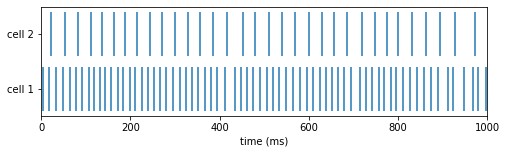

In [66]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 2))

for i, data in enumerate([cell1_times, cell2_times]):
    ax.vlines(data.as_numpy(), i - 0.4, i + 0.4)

ax.set_yticks([0, 1])
ax.set_yticklabels(["cell 1", "cell 2"])

ax.set_xlim([0, h.t])
ax.set_xlabel("time (ms)")

What if we change tau so that `cell2` does not integrate as well anymore

In [79]:
cell2.tau = 0.4 * ms

Text(0.5, 0, 'time (ms)')

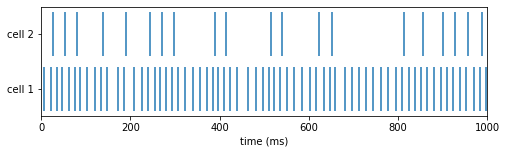

In [81]:
# Run the simulation
h.finitialize(-65 * mV)
h.continuerun(1000 * ms)

# Plot results
fig, ax = plt.subplots(figsize=(8, 2))

for i, data in enumerate([cell1_times, cell2_times]):
    ax.vlines(data.as_numpy(), i - 0.4, i + 0.4)

ax.set_yticks([0, 1])
ax.set_yticklabels(["cell 1", "cell 2"])

ax.set_xlim([0, h.t])
ax.set_xlabel("time (ms)")

Let's add a third inhibitory cell

In [83]:
# Initialise cell
cell3 = h.IntFire1()
cell3.tau = 2 * ms
cell3.refrac = 10 * ms

# Add a stimulus to cell 3 - but start at 400ms
e_stims3 = h.NetStim()
e_stims3.noise = 0.5
e_stims3.interval = 3 * ms
e_stims3.start = 400 * ms
e_stims3.number = 1e10

# Initialize the connection between stimulus and the cell
nc3 = h.NetCon(e_stims3, cell3)
nc3.weight[0] = 1  # a high weight will make sure cell 1 actually fires
nc3.delay = 0 * ms  # the delay between presynaptic spike and postsynaptic current

# Setup recordings
cell3_times = h.Vector()
cell3_times_nc = h.NetCon(cell3, None)
cell3_times_nc.record(cell3_times)

0.0

In [84]:
# Connect cell 3 -> 2 with negative weight
cn2 = h.NetCon(cell3, cell2)
cn2.weight[0] = -1  # negative weight
cn2.delay = 5 * ms  # Give it a bit of a delay

Text(0.5, 0, 'time (ms)')

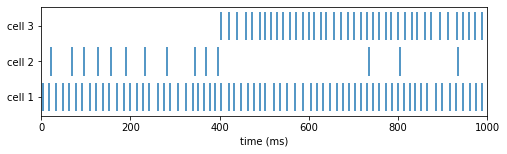

In [85]:
# Run the simulation
h.finitialize(-65 * mV)
h.continuerun(1000 * ms)

# Plot results
fig, ax = plt.subplots(figsize=(8, 2))

for i, data in enumerate([cell1_times, cell2_times, cell3_times]):
    ax.vlines(data.as_numpy(), i - 0.4, i + 0.4)

ax.set_yticks([0, 1, 2])
ax.set_yticklabels(["cell 1", "cell 2", "cell 3"])

ax.set_xlim([0, h.t])
ax.set_xlabel("time (ms)")

Note how the inhibition from `cell 3` lowers the firing rate in `cell 2`?

As you probably noticed `NEURON` requires writing a lot of boilerplate and 
it quickly becomes unyieldy as your networks increase in size.

The solution for this would be to write a e.g. `Class` that abstracts away some 
of those complexities. [NetPyne](http://www.netpyne.org/), for example, is a
third party library that wraps `NEURON` and makes it easy to construct and 
simulate large networks. It is, however, designed primarily for probabilistic
(mammalian) networks and not well suited for our purposes.

Fortunately, [navis](https://navis.readthedocs.io/) has a simple `PointNetwork`
class that we can leverage to generate and analyse networks.

Let's re-implement the above 3-cell network using navis:

In [128]:
# First we make an edge list reflecting our target connectivity
import pandas as pd

edges = pd.DataFrame([])
edges["source"] = ["1", "3"]
edges["target"] = ["2", "2"]
edges["weight"] = [1, -1]
edges

,source,target,weight
0,1,2,1
1,3,2,-1


In [129]:
import navis.interfaces.neuron as nrn

# Generate network from edge list
net = nrn.PointNetwork.from_edge_list(edges, model="IntFire1")
net

PointNetwork<neurons=3,edges=2>

In [130]:
# Set properties for all neurons in the network
for cell in net.neurons:
    cell.process.tau = 4 * ms
    cell.process.refrac = 10 * ms

# Set delay for all edges
for edge in net.edges:
    edge[3].delay = 5 * ms

In [131]:
# Add the two stimuli
net.add_stimulus("1", start=0, stop=1000, frequency=100, randomness=0)
net.add_stimulus("3", start=400, stop=700, frequency=100, randomness=0)

By default, the `PointNetwork` will automatically add recordings to all 
neurons. So we're good to run our simulation.

In [132]:
# Run simulation
net.run_simulation(1000)

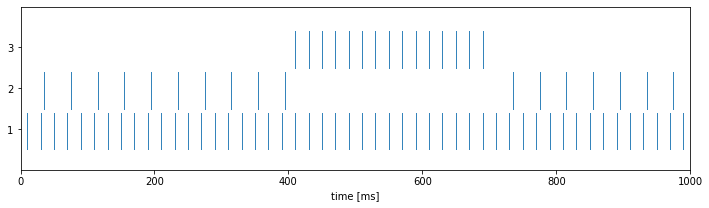

In [133]:
# Plot
ax = net.plot_raster(backend="matplotlib", label=True, stimuli=False)